In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# ============= Import required packaages ==============
import time
import os
import tensorflow as tf

# Import all custom variables and modules
from custom_classes_defs.setup import *
from custom_classes_defs.preprocessing import *
from custom_classes_defs.Unet_like import *   
from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 256
keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

from tensorflow.data import Dataset as tf_data
# -------------------------------------------------------

### Data preparation and model configurations

---------------

In [4]:
class SeismicData():
    """
    Loading, scaling and preprocessing of the seismic data:
    Returns: tf-datasets
    """
    def __init__(self,
            input_img_paths,
            target_img_paths,
            img_size=(96, 96),
            batch_size=100
        ):
        #super().__init__()
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.img_size = img_size
        self.batch_size = batch_size
    
    def load_img_masks(self,path):
        data = []
        for file_name in os.listdir(path):
            file_path = os.path.join(path, file_name)
            if file_name.endswith('.npy'):
                numpy_array = np.load(file_path)
                print(f"Array loaded from '{file_name}' has shape: {numpy_array.shape}")
                data.append(numpy_array)
        print(f"\nThe concatenated array has shape: {np.shape(data)}")
        return np.array(data)

    def get_dataset(self):
        """Returns a TF Dataset."""
        x_train =self.load_img_masks(self.input_img_paths)
        y_train = self.load_img_masks(self.target_img_paths)
        dataset = tf_data.from_tensor_slices((x_train, y_train))
        #dataset = dataset.prefetch(num_parallel_calls=tf_data.AUTOTUNE)
        return dataset.batch(self.batch_size)
    

In [5]:
seis_data_path = 'data_preprocessing/processed_data_temp/seis_train/'
fault_data_path = 'data_preprocessing/processed_data_temp/fault_train/'

seis_val_path = 'data_preprocessing/processed_data_temp/seis_val/'
fault_val_path = 'data_preprocessing/processed_data_temp/fault_val/'

train_data = SeismicData(seis_data_path,fault_data_path)
validation_data = SeismicData(seis_val_path,fault_val_path)

train_dataset = train_data.get_dataset()
val_dataset = validation_data.get_dataset()

Array loaded from '0.npy' has shape: (96, 96)
Array loaded from '1.npy' has shape: (96, 96)
Array loaded from '10.npy' has shape: (96, 96)
Array loaded from '100.npy' has shape: (96, 96)
Array loaded from '1000.npy' has shape: (96, 96)
Array loaded from '101.npy' has shape: (96, 96)
Array loaded from '102.npy' has shape: (96, 96)
Array loaded from '103.npy' has shape: (96, 96)
Array loaded from '104.npy' has shape: (96, 96)
Array loaded from '105.npy' has shape: (96, 96)
Array loaded from '106.npy' has shape: (96, 96)
Array loaded from '107.npy' has shape: (96, 96)
Array loaded from '108.npy' has shape: (96, 96)
Array loaded from '109.npy' has shape: (96, 96)
Array loaded from '11.npy' has shape: (96, 96)
Array loaded from '110.npy' has shape: (96, 96)
Array loaded from '111.npy' has shape: (96, 96)
Array loaded from '112.npy' has shape: (96, 96)
Array loaded from '113.npy' has shape: (96, 96)
Array loaded from '114.npy' has shape: (96, 96)
Array loaded from '115.npy' has shape: (96, 9

In [6]:
seis_test_path = 'data_preprocessing/processed_data_temp/seis_test'
fault_test_path = 'data_preprocessing/processed_data_temp/fault_test/'

test_data = SeismicData(seis_test_path,fault_test_path)
test_seismic = test_data.load_img_masks(seis_test_path)

test_label = test_data.load_img_masks(fault_test_path)
np.shape(test_label)

Array loaded from '0.npy' has shape: (96, 96)
Array loaded from '1.npy' has shape: (96, 96)
Array loaded from '10.npy' has shape: (96, 96)
Array loaded from '100.npy' has shape: (96, 96)
Array loaded from '101.npy' has shape: (96, 96)
Array loaded from '102.npy' has shape: (96, 96)
Array loaded from '103.npy' has shape: (96, 96)
Array loaded from '104.npy' has shape: (96, 96)
Array loaded from '105.npy' has shape: (96, 96)
Array loaded from '106.npy' has shape: (96, 96)
Array loaded from '107.npy' has shape: (96, 96)
Array loaded from '108.npy' has shape: (96, 96)
Array loaded from '109.npy' has shape: (96, 96)
Array loaded from '11.npy' has shape: (96, 96)
Array loaded from '110.npy' has shape: (96, 96)
Array loaded from '111.npy' has shape: (96, 96)
Array loaded from '112.npy' has shape: (96, 96)
Array loaded from '113.npy' has shape: (96, 96)
Array loaded from '114.npy' has shape: (96, 96)
Array loaded from '115.npy' has shape: (96, 96)
Array loaded from '116.npy' has shape: (96, 96

(151, 96, 96)

In [7]:

# Model configurations
conf = model_config(
    epochs=50,
    #batch_size=BATCH_SIZE,
    batch_size=100,
    shuffle=True,
    scaling=1,
    img_shape=(96,96), 
    target_size=(96,96), 
    verbose=1,
    save_path='./data_preprocessing/processed_data_temp/output_temp/',
    augmentation=True
)


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

conf.set( validation_data=val_dataset,  callbacks=[es_callback] )
conf.set('compile')
conf.info()

        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
       training_args:
                        epochs: 50
                    batch_size: 10
                       shuffle: True
                       verbose: 1
               validation_data: <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
                     callbacks: <class 'list'>
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: True
new_training_session: False
           save_path: ./data_preprocessing/processed_data_temp/output_temp/
           threshold: 0.5
           pos_label: 1


In [8]:
### Interactive step:
if INTERACTIVE_SESSION:
    train = input("New train session? (y/n): ")
    if train[0].lower()=='y':
        conf.new_training_session = True
    else:
        conf.new_training_session = False
    interact = input("Are you sure, you want to run this session interactively? (y/n): ")
    if interact[0].lower()!='y':
        INTERACTIVE_SESSION = False

### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))
m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
#m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)

model = m_obj.build_model()
model.summary()
#keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
print(f"Total trainable wieghts: {model.count_params():,}")




	Build model
-------------------------------------------------------


Model: "U-NET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 96, 96, 1) │          0 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        320 │ sequential[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 48, 48,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 48, 48,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 48, 48,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 24, 24,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 24, 24,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ separable_conv2d

 Total params: 2,057,825 (7.85 MB)

 Trainable params: 2,054,049 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

Total trainable wieghts: 2,057,825


### Train and evaluate  model



	Train unet model
-------------------------------------------------------
Model training...
Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - loss: 1.2466 - val_loss: 0.3412
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.3799 - val_loss: 0.3198
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.3597 - val_loss: 0.3192
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 0.3585 - val_loss: 0.3088
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 0.3575 - val_loss: 0.3064
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.3525 - val_loss: 0.3033
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - loss: 0.3532 - val_loss: 0.3029
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 0.3517 - val_loss: 0.3086
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 0.3534 - val_loss: 0.3033
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - loss: 0.3512 - val_loss: 0.3036
Epoch 11/50
101

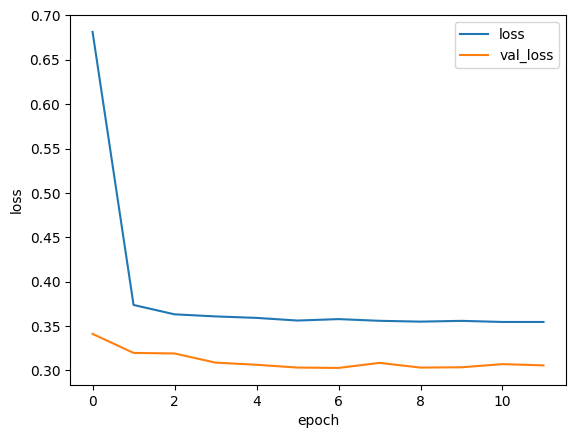

In [10]:

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

conf.execute_training(
    model, 
    data=train_dataset, 
    saveas=m_obj.Name, 
    plot_history=INTERACTIVE_SESSION
)


In [11]:
x_test = np.expand_dims(test_seismic,axis=-1)
y_test = test_label

In [12]:
x_test.shape
y_test.shape

(151, 96, 96)

In [13]:


print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
# fault label probabilities
decoded_imgs = model.predict(x_test)
scores = m_obj.evaluate_sklearn(y_test, decoded_imgs,report=True)
print(scores)



	Evaluate unet model
-------------------------------------------------------
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step
evaluation elapsed time:___ 0.05___minutes
{'Avg-precision': 0.12, 'f1-score(ODS)': 0.2, 'f1-score(OIS)': 0.2}


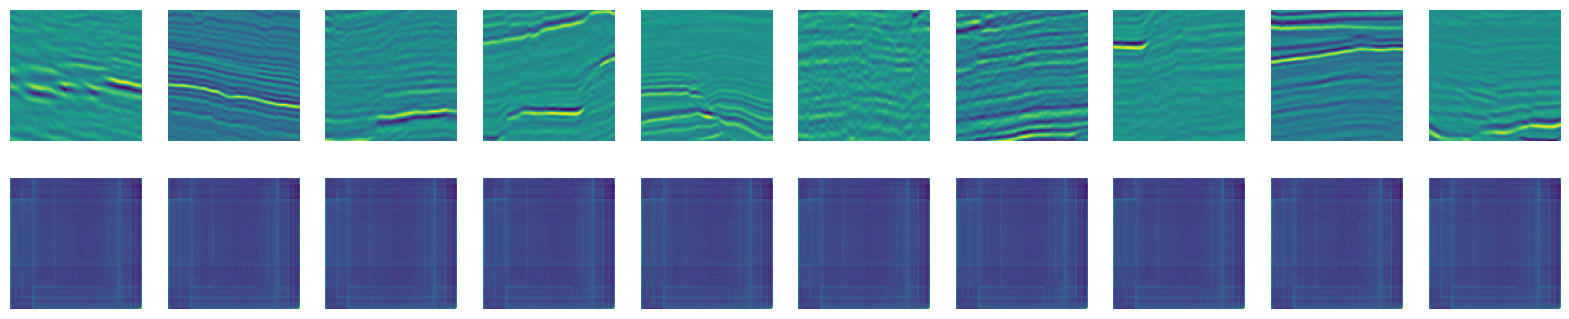

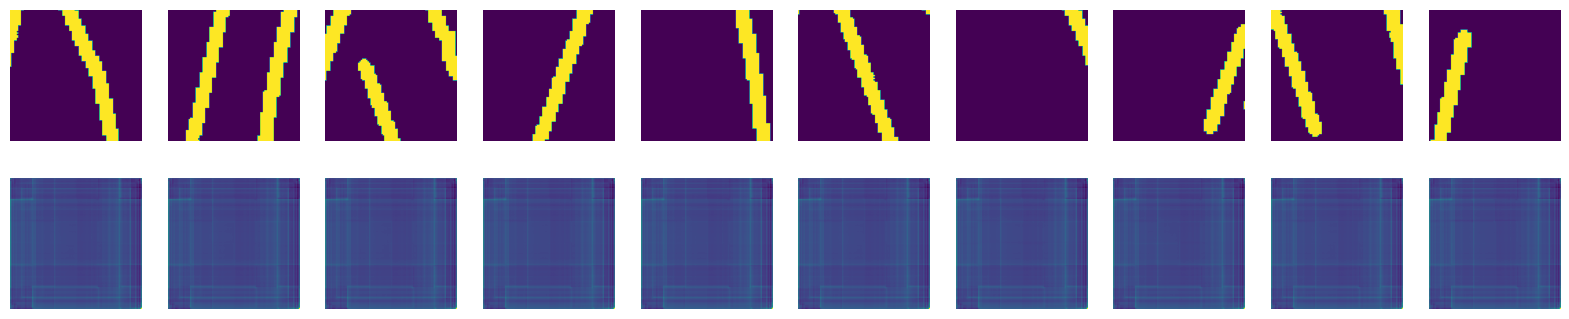

In [19]:
if INTERACTIVE_SESSION:
    display_sample_images(x_test, decoded_imgs, conf.img_shape)
    display_sample_images(y_test, decoded_imgs, conf.img_shape)

In [15]:
import cv2

def threshold_image(image, threshold_value):
    _, binary_image = cv2.threshold(image, threshold_value, 1, cv2.THRESH_BINARY)
    return binary_image

threshold_label = threshold_image(decoded_imgs,0.5)

In [16]:
decoded_imgs.shape

(151, 96, 96, 1)

In [17]:
threshold_label.shape

(151, 96)